# پرسش ۱

# آ

ابتدا، داده‌های ورودی را به صورت یک سری زمانی در نظر می‌گیریم. حال از آنجایی که سعی داریم یک مدل قطعه‌قطعه خطی روی داده‌ها فیت کنیم، پس برای سادگی می‌توانیم ابتدا داده‌ها را با یک مدل چند جمله‌ای تقریب بزنیم زیرا یک تابع چند جمله‌ای، در بازه‌های میان اکسترمم‌ها، رفتار تقریبا خطی دارد. پس در صورتی که یک مدل با $k$
ضابطه خطی، بهترین تقریب زننده باشد، یک مدل چند جمله‌ای با درجه حداقل $k$
نیز یک تقریب زننده خوب برای داده‌هاست.  
در نتیجه می‌توان درجات مختلف چند جمله‌ای را روی داده‌ها برازش کرد و اولین درجه‌ای که خطا را به طور محسوسی کاهش دهد را به عنوان $k$
در نظر بگیریم. (همانند روش $\text{elbow}$
در $\text{k-means}$
تصمیم می‌گیریم)۰  

حال نیاز داریم تا نقاط مرزی ضابطه‌های خطی مدل را به دست آوریم. برای این کار، با توجه به توضیحات بالا، کافی‌ست اکسترمم‌های چندجمله‌ای برازش شده را به دست آوریم تا محل شکستگی در داده مشخص شود. سپس برای تخمین خطوط، از روش کمترین مربعات خطی، برای هر بازه استفاده می‌کنیم و در نهایت برای اجبار کردن پیوستگی تابع نهایی، نقاط مرزی ضابطه‌ها را برابر با محل برخورد آن‌ها قرار دهیم و به این صورت یک تابع خطی چند ضابطه‌ای به دست می‌آید۰   

البته می‌توانیم روش بند قبل چند بار انجام دهیم تا توابع خطی به دست آمده، به داده‌ها میل کنند و نقاط مرزی ایده‌آل تر شوند؛ یعنی هر بار که نقاط مرزی را به روز کردیم، دوباره داده‌های هر بازه را برازش خطی کنیم و این کار را تکرار کنیم۰

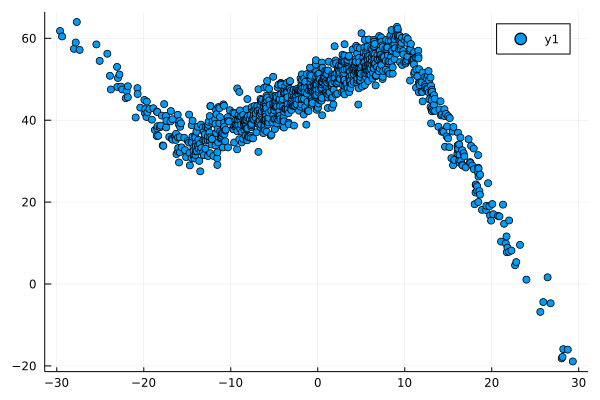

In [1]:
using LinearAlgebra, DelimitedFiles, Plots, Clustering, Polynomials, Peaks, Printf

points = readdlm("./data/data1.txt", ' ')
points = points[sortperm(points[:, 1]), :]
display(scatter(points[:, 1], points[:, 2]))

در اینجا خطای مدل چندجمله‌ای را بر حسب درجه آن رسم میکنیم و آخرین نقطه با کاهش خطای محسوس را به عنوان درجه چندجمله‌ای در نظر می‌گیریم۰ 

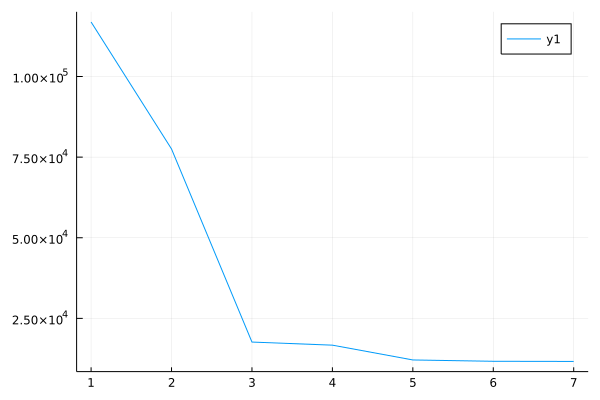

In [2]:
ervs = []
for i = 1:7
    p = fit(points[:, 1], points[:, 2], i)
    erv = p.(points[:, 1]) - points[:, 2]
    erv = sum(erv .^ 2)
    push!(ervs, erv)
end
display(plot(ervs))

همانطور که مشاهده میکنید، در $k=3$
آخرین کاهش خطای محسوس است. البته ۵ نیز یک انتخاب مناسب است ولی دلیل کاهش در ۵، وجود اثر رانگه در ۳ است. زیرا قطعات اول و آخر، خارج از بازه اکسترمم‌ها و در قسمت‌های مرزی قرار دارند. پس نوساناتی در آن‌ها رخ می‌دهد که از خطی بودن خارج می‌شوند۰

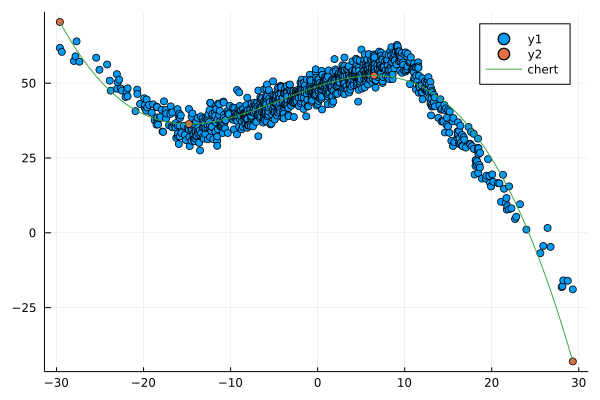

In [3]:
k = 3
f = fit(points[:, 1], points[:, 2], k)

anchors =[1;argmaxima(f.(points[:, 1]));argminima(f.(points[:, 1]));length(points[:, 1])]
anchors = anchors[:,1]
sort!(anchors)

scatter(points[:, 1], points[:, 2])
scatter!(points[anchors, 1], f.(points[anchors, 1]))
display(plot!(f, extrema(points[:, 1])..., label = "chert"))

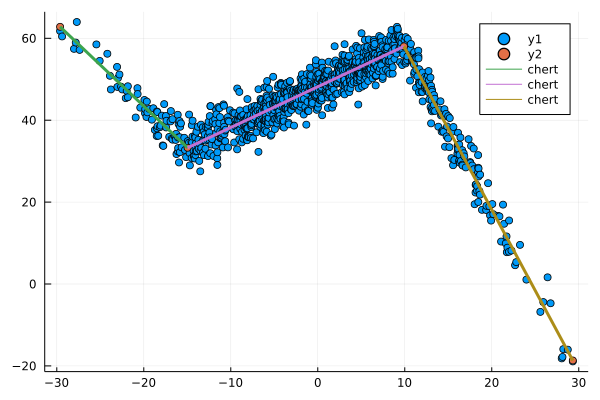

In [6]:
function linear_regression(pts)
    A = [pts[:, 1] ones((size(pts)[1], 1))]
    b = pts[:, 2]
    x = A \ b
    err = norm(b - A * x)
    return x, err
end

function line_intersection(l1,l2)
    return (l2[2]-l1[2])/(l1[1]-l2[1])
end

function eval_line(line, x)
    return line[1] * x + line[2]
end

anchors_x = points[anchors]
anchors_y = f.(anchors_x)
lines = zeros((k,2))
for t=1:3
    for i=1:k
        anchors[i] = searchsortedfirst(points[:, 1], anchors_x[i])
        anchors[i+1] = searchsortedfirst(points[:, 1], anchors_x[i+1])
        lines[i,:] = linear_regression(points[anchors[i]:anchors[i+1], :])[1]
    end

    for i = 2:k
        anchors_x[i] = line_intersection(lines[i-1,:],lines[i,:])

        anchors_y[i-1] = eval_line(lines[i-1,:], anchors_x[i-1])
        anchors_y[i] = eval_line(lines[i-1,:], anchors_x[i])
        anchors_y[i+1] = eval_line(lines[i,:], anchors_x[i+1])
    end
end

plt = scatter(points[:, 1], points[:, 2])
scatter!(anchors_x, anchors_y)

for i = 1:k
    mpts = points[anchors[i]:anchors[i+1], :]
    ps(x) = eval_line(lines[i,:],x)
    plot!(plt, ps, anchors_x[i], anchors_x[i+1], label = "chert", lw = 3)
end
display(plt)

In [7]:
println("anchor points:")
for i=1:(k+1)
    @printf("%.2f ", anchors_x[i])
end
println()

println("lines:")
for i=1:k
    @printf("y = %.2fx + %.2f\n", lines[i, 1], lines[i, 2])
end
println()



anchor points:
-29.62 -14.96 9.91 29.32 
lines:
y = -2.01x + 3.12
y = 1.00x + 48.17
y = -3.95x + 97.19

